# Generate model inputs

## This will set up the forcing for Abernathey Style Forcing

In [4]:
from scipy.io import netcdf
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import netCDF4
import sys
import math
from pylab import *
from IPython.display import display, Math, Latex
from numba import jit
import glob
%matplotlib inline
# Use writeFile to write files in the correct format!
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
from Writebin import *

When writing in python it is very important to note reverse dimensions!!
MITgcm assumes column major order (as does matlab) Python, uses row major order.
Mosty it's fine just to write straight to binary, but to absolutely specific of the format for MITgcm the WriteFile fuction (taken from the MITgcm csv gendata.py):

## Decide parameters:

In [5]:
Topo="flat"  # Please Choose ridge, slope or flat
Wind="Standard"  # Sine bell 0.2N/m$^2$
Heat="Abernathey"  # Please Choose Abernathey or nonetQ
BC="Sponge"  # Please Choose Sponge or Diffusion
Name="50m"  # Give Experiment Name
D=250  # If diffusion then max diffusion enhancement is required

In [6]:
# Adjust accordingly
Res = 5000
Ly = 2000e3
Lx = 1000e3 #Full domain = 4000km otherwise 1000km
H=  3000 # Diffusion = 3800m, Sponge = 2985m
nz = 30 # Diffusion = 24 level, Sponge= 30 levels

In [7]:
x = ( os.path.expanduser('~')+"/MITgcm/"+Name+"/input/")
if not os.path.exists(x):
       os.makedirs(x) 
os.chdir(x)

## Set up grid:

In [8]:
#Dimensions
nx = np.round(Lx/Res)
ny = np.round(Ly/Res)
dx = np.ones(nx)*Res
dy = np.ones(ny)*Res
#Write binary output
writeFile('delY',dy)
writeFile('delX',dx)
# Create c-grid with grid points in dead center
x = (np.cumsum(dx)-dx/2)-Lx/2
y = (np.cumsum(dy)-dy/2)-Ly/2
[Y, X] = np.meshgrid(y, x) 

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


## Now Create topography:

Start with flat, then add slope and ridges

In [9]:
h= -H*np.ones((nx,ny)) # Flat bottom
if Topo == "ridge":#2500 and 2000 for full depth
        h= h+((2500 + 300*np.sin(10*pi*Y/Ly) + 400*np.sin(8*pi*Y/Ly)
               + 300*sin(25*pi*Y/Ly) )*(1/np.cosh(((X)-0.2*Y+3e5)/1.2e5)))
        h= h+((2000 + 600*np.sin(11*pi*Y/Ly) + 300*np.sin(7*pi*Y/Ly)+
               500*sin(21*pi*Y/Ly) )*(1/np.cosh(((X)+0.1*Y+1.5e6)/1.2e5)))
if Topo == "slope" or Topo=="ridge":
    for i in range(int(nx)):
        slope= np.transpose(H*(np.divide((Y[i,0:round(0.2*ny)]
                                          -Y[i,0]),(Y[i,0]-Y[i,round(0.2*ny)]))))
        h2 = h[:,0:round(0.2*ny)]
        h[:,0:round(0.2*ny)]=np.maximum(slope,h2)
# Close both ends
h[:,0] = 0
h[:,-1] = 0
# Write to binary
writeFile('topog',np.transpose(h))

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


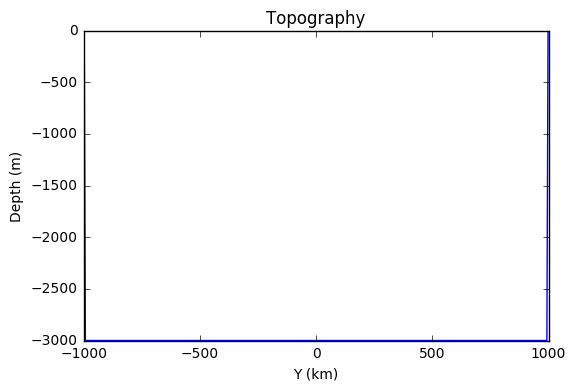

In [10]:
fig1 = plt.figure()
if Topo == "flat" or Topo == "slope":
    plt.plot(y/1000,h[nx/2,:])
    plt.title('Topography')
    plt.ylabel('Depth (m)')
    plt.xlabel('Y (km)')
if Topo == 'ridge':
    # plt.contourf(x/1000,y/1000,np.transpose(h),30)
    plt.contourf(np.transpose(h))
    cb = plt.colorbar()
    plt.title('Topography')
    plt.ylabel('Y (km)')
    plt.xlabel('X (km)')
    cb.set_label('Depth (m)')
# netcdf check
f = netCDF4.Dataset('topog.nc','w')
f.createDimension('X',nx)
f.createDimension('Y',ny)
h2=f.createVariable('h','float',('X','Y'))
h2[:] = h
f.close()


## Surface Heat Forcing

Now for the surface heat forcing:
Must have bouyancy gain in the south and bouyancy loss over maximum wind sress to allow overturning


$Q=-Q_{0}\,cos(\frac{3\pi y}{Ly})\quad \quad \quad \quad y \le \frac{5Ly}{6}$

In [11]:
#MITgcm opposite way round
Q_0 = 10
Q=Q_0*(np.sin(Y*(3*pi/Ly)))
Q[:,ny-(np.round(ny/6)):ny]=0
x1 = (np.cumsum(dx)-dx/2)
y1 = (np.cumsum(dy)-dy/2)
[Y1, X1] = np.meshgrid(y1, x1) 
if Heat=="nonetQ":
    Q[:,0:int(5*ny/36)]=Q_0*(np.cos(Y1[:,0:int(5*ny/36)]*(pi/(Y1[1,int(10*ny/36)]))))
    Q[:,int(5*ny/36):int(20*ny/36)]= -Q_0*(np.sin((Y1[:,int(5*ny/36):int(20*ny/36)]
                                                 -Y1[1,int(5*ny/36)])*(pi/(Y1[1,int(15*ny/36)]))))
    Q[:,int(20*ny/36):int(30*ny/36)]= Q_0*(np.sin(Y1[:,0:int(10*ny/36)]*(pi/(Y1[1,int(10*ny/36)]))))
    Q[:,0:int(30*ny/36)] = Q[:,0:int(30*ny/36)]+(-sum(Q)/(5*ny*nx/6)) 
# Write to binary
writeFile('Qsurface',np.transpose(Q))
# netcdf check
f=netcdf.netcdf_file('Qsurface.nc','w')
f.createDimension('X',nx)
f.createDimension('Y',ny)
Q2=f.createVariable('Q','float',('X','Y'))
Q2[:]=Q
f.close()

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/scipy/io/netcdf.py:373: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  data = empty(shape_, dtype=type.newbyteorder("B"))  # convert to big endian always for NetCDF 3


In [12]:
'''The 0.8, 10.5 and 11 above are used to force the heat flux to as 
   close as possible and then the last line forces the net flux to 0
   It is best to check this!!!!'''
sum(Q)

84881.981801899761

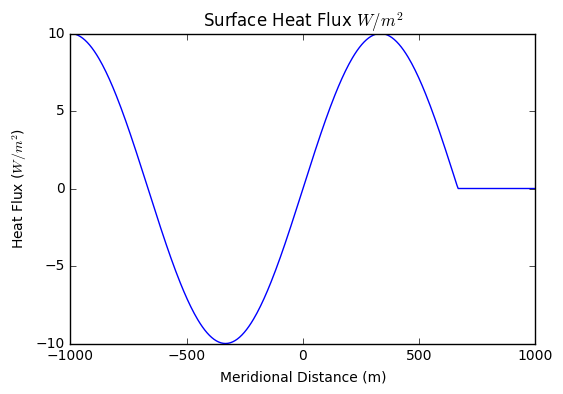

In [13]:
fig1 = plt.figure()
plt.plot(y/1000,Q[100,:])
plt.title('Surface Heat Flux $W/m^2$')
plt.ylabel('Heat Flux ($W/m^2$)')
plt.xlabel('Meridional Distance (m)')

## Windstress

Plus the Windress with $\tau_o$ set to $0.2Nm^-2$

$\tau_s(y)=\tau_0 sin(\frac{\pi y}{Ly})$

In [14]:
tau=0.2*((np.sin((Y+Ly/2)*(pi/Ly)))) #Y is centred at 0 so put that back!
if BC=='Diffusion':
    Taunew = tau + 2e-3 * (np.random.random((nx,ny)) - 0.5)
    tau=Taunew
# Write to binary
writeFile('Wind',np.transpose(tau))
# netcdf check
f=netcdf.netcdf_file('Wind.nc','w')
f.createDimension('Xp1',nx+1)
f.createDimension('Y',ny)
tau3=np.zeros((ny,nx+1))
tau3[:,1:]=np.transpose(tau)
tau2=f.createVariable('tau','double',('Xp1','Y'))
tau2[:]=np.transpose(tau3)
f.close()

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


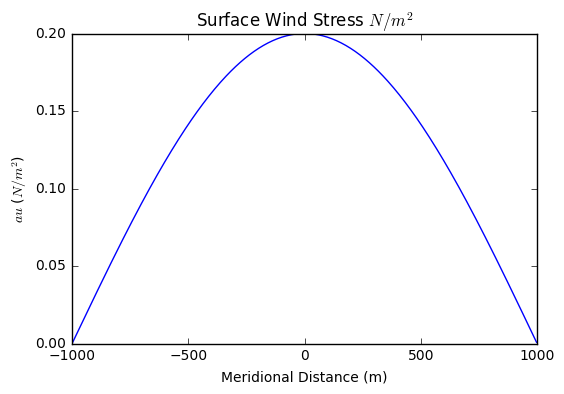

In [15]:
plt.plot(y/1000,tau[100,:])
plt.title('Surface Wind Stress $N/m^2$')
plt.ylabel('$\tau$ ($N/m^2$)')
plt.xlabel('Meridional Distance (m)')

## Generate Sponge

In [16]:
# Parameters
N = 0.05e3 # Natural stratification
deltaT = 8#
Tref=np.zeros(nz)
# Create depth array:
# Tanh - normal
zp = np.linspace(1,0,31)
zp = H+H*(tanh(-pi*zp))
zp = zp - zp[0]-(zp[1]-zp[0])
zp = np.round(zp,2)
dz = zp[0:-1] - zp[1::]
zp[-1] = H
zp[1::] = np.cumsum(dz)
zp[0] = 0.5*zp[0]
writeFile('delZ',-dz)
# Z center points
z = zeros((nz))
z[1::] = (zp[1:-1]+zp[2::])/2
z[0]= zp[0]/2

\begin{equation*} T^*(z)=\Delta T\frac{(e^{z/h}-e^{-H/h})}{1-e^{-H/h}} \end{equation*}

In [27]:
Tref = deltaT*(exp(z/N)-exp(-H/N))/(1-exp(-H/N))+((N-N0)/N0)
if N > H:
    Tref = deltaT*(exp(z/N)-exp(-H/N))/(1-exp(-H/N))+1+((H-N0)/N0)

max:  7.80875290426 
 min:  -0.95


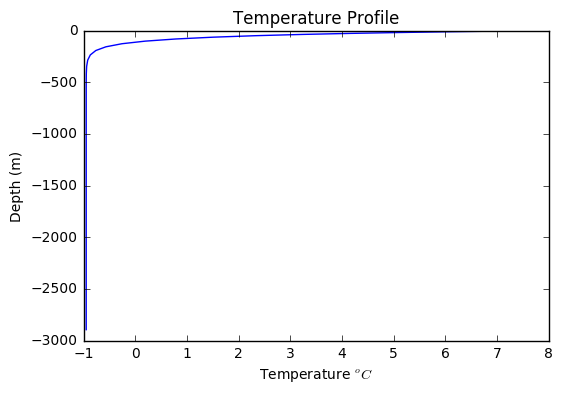

In [20]:
plt.plot(Tref,z)
print 'max: ', np.max(Tref), '\n min: ', np.min(Tref)
#plt.gca().invert_yaxis()
plt.title('Temperature Profile')
plt.ylabel('Depth (m)')
plt.xlabel('Temperature $^oC$')

In [21]:
#Make a 3D array of it
T=np.ones((nz,ny,nx))
Temp_field=np.zeros(np.shape(T))
for i in range(int(nx)):
    for j in range(int(ny)):
        Temp_field[:,j,i]=np.multiply(Tref,T[:,j,i])

In [22]:
Tnew = transpose(tile(Temp_field.mean(axis=2),(nx,1,1)),[1,2,0])
Tnew[:,-1] = Tnew[:,-2]
#Maybe add more 
if BC=='Diffusion':
    Tnew = Tnew + 2e-3 * (np.random.random((nz,ny,nx)) - 0.5)
else:
    Tnew = Tnew + 1e-3 * (np.random.random((nz,ny,nx)) - 0.5)

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/numpy/lib/shape_base.py:873: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return c.reshape(shape_out)
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [23]:
# Write to binary
writeFile('T_Sponge',Temp_field)
writeFile('T.init',Tnew)
# netcdf check
f=netcdf.netcdf_file('TSponge.nc','w')
f.createDimension('X',nx)
f.createDimension('Y',ny)
f.createDimension('Z',nz)
Temp=f.createVariable('Temp','double',('Z','Y','X'))
Temp[:]=Temp_field
f.close()

In [24]:
#Make 3D mask
#Must vary between 0 (no Relaxation) and 1 (full relaxtion)
#I have gone for a parabolic decay in x and linear decay in z (from playing around)
msk=np.zeros(np.shape(T))
for k in range(0,len(z)):
    for i in range(len(x)):  
        msk[k,ny-20:ny,i]=((np.divide((Y[i,ny-21:ny-1]-Y[i,ny-21]),(Y[i,ny-1]-Y[i,ny-21]))))\
        #*(z[k]/H)    
# Write to binary
writeFile('T.msk',msk)
# netcdf check
f=netcdf.netcdf_file('Mask.nc','w')
f.createDimension('X',nx)
f.createDimension('Y',ny)
f.createDimension('Z',nz)
Mask=f.createVariable('Mask','double',('Z','Y','X'))
Mask[:]=(msk)
f.close()

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


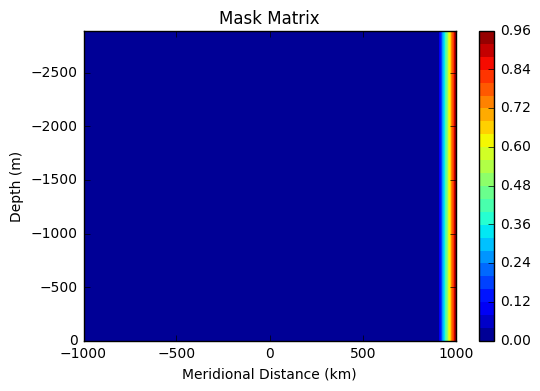

In [25]:
plt.contourf(y/1000,z,msk[:,:,100],24,cm=cm.Spectral)
cbar = plt.colorbar()
plt.gca().invert_yaxis()
plt.title('Mask Matrix')
plt.ylabel('Depth (m)')
plt.xlabel('Meridional Distance (km)')